<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-11 16:45:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-08-11 16:45:33 (267 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male

In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

# Data visualization and pre-processing



Let’s see how many of each class are in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.6.24-0        --> 2020.6.24-0       anaconda
    certifi:         2020.6.20-py36_0   --> 2020.6.20-py36_0  anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

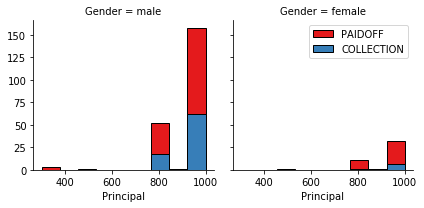

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

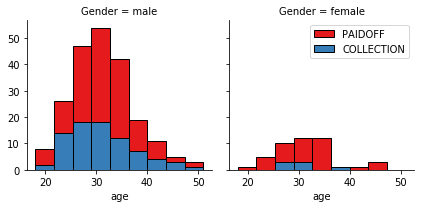

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

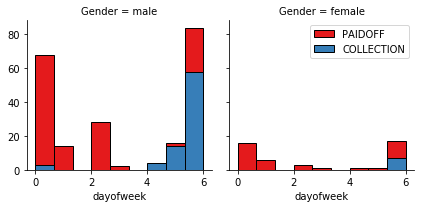

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below    male          3        0  
1 2016-10-07   33              Bechalor  female          3        0  
2 2016-09-22   27               college    male          3        0  
3 2016-10-08   28               college  female          4        1  
4 2016-10-08   29               college    male          4        1

## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1

## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [28]:
#Split our X, y into testing and training sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [29]:
#Using our training and test sets, create KNN classifiers with k = 1-15 neighbors and then evaluate each model
#using metrics.accuracy_score, which is equivalent to Jaccard Index.

Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.jaccard_similarity_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

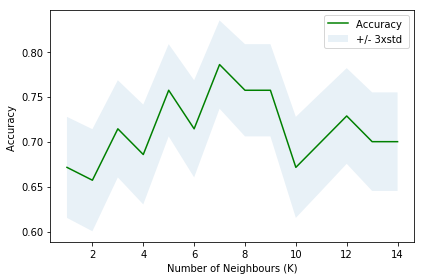

In [30]:
#Plot the accuracy at each k

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [31]:
#Create classifier with k = 7 (k with greatest accuracy)
knnClassifier =  KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
yhat_KNN = knnClassifier.predict(X_test)

In [32]:
#Find Jaccard Index
print("Train set Accuracy: ", metrics.jaccard_similarity_score(y_train, knnClassifier.predict(X_train)))
print("Test set Accuracy: ", metrics.jaccard_similarity_score(y_test, yhat_KNN))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [33]:
#Find F1 Score
print("Train accuracy, F1 Score: ", f1_score(y_train, knnClassifier.predict(X_train), average='weighted'))
print("Test accuracy, F1 Score: ", f1_score(y_test, yhat_KNN, average='weighted'))

Train accuracy, F1 Score:  0.8000194668761034
Test accuracy, F1 Score:  0.7766540244416351


# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
#Create classifier, fit, and predict
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_train, y_train)
yhat_tree = loanTree.predict(X_test)

In [36]:
#Find Jaccard Index
print("Train set Accuracy: ", metrics.jaccard_similarity_score(y_train, loanTree.predict(X_train)))
print("Test set Accuracy: ", metrics.jaccard_similarity_score(y_test, yhat_tree))

Train set Accuracy:  0.7463768115942029
Test set Accuracy:  0.6142857142857143


In [37]:
#Find F1 Score
print("Train accuracy, F1 Score, poly: ", f1_score(y_train, loanTree.predict(X_train), average='weighted'))
print("Test accuracy, F1 Score, poly: ", f1_score(y_test, yhat_tree, average='weighted'))

Train accuracy, F1 Score, poly:  0.757416213768116
Test accuracy, F1 Score, poly:  0.6445993031358885


In [39]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [40]:
#Make tree, using training data
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

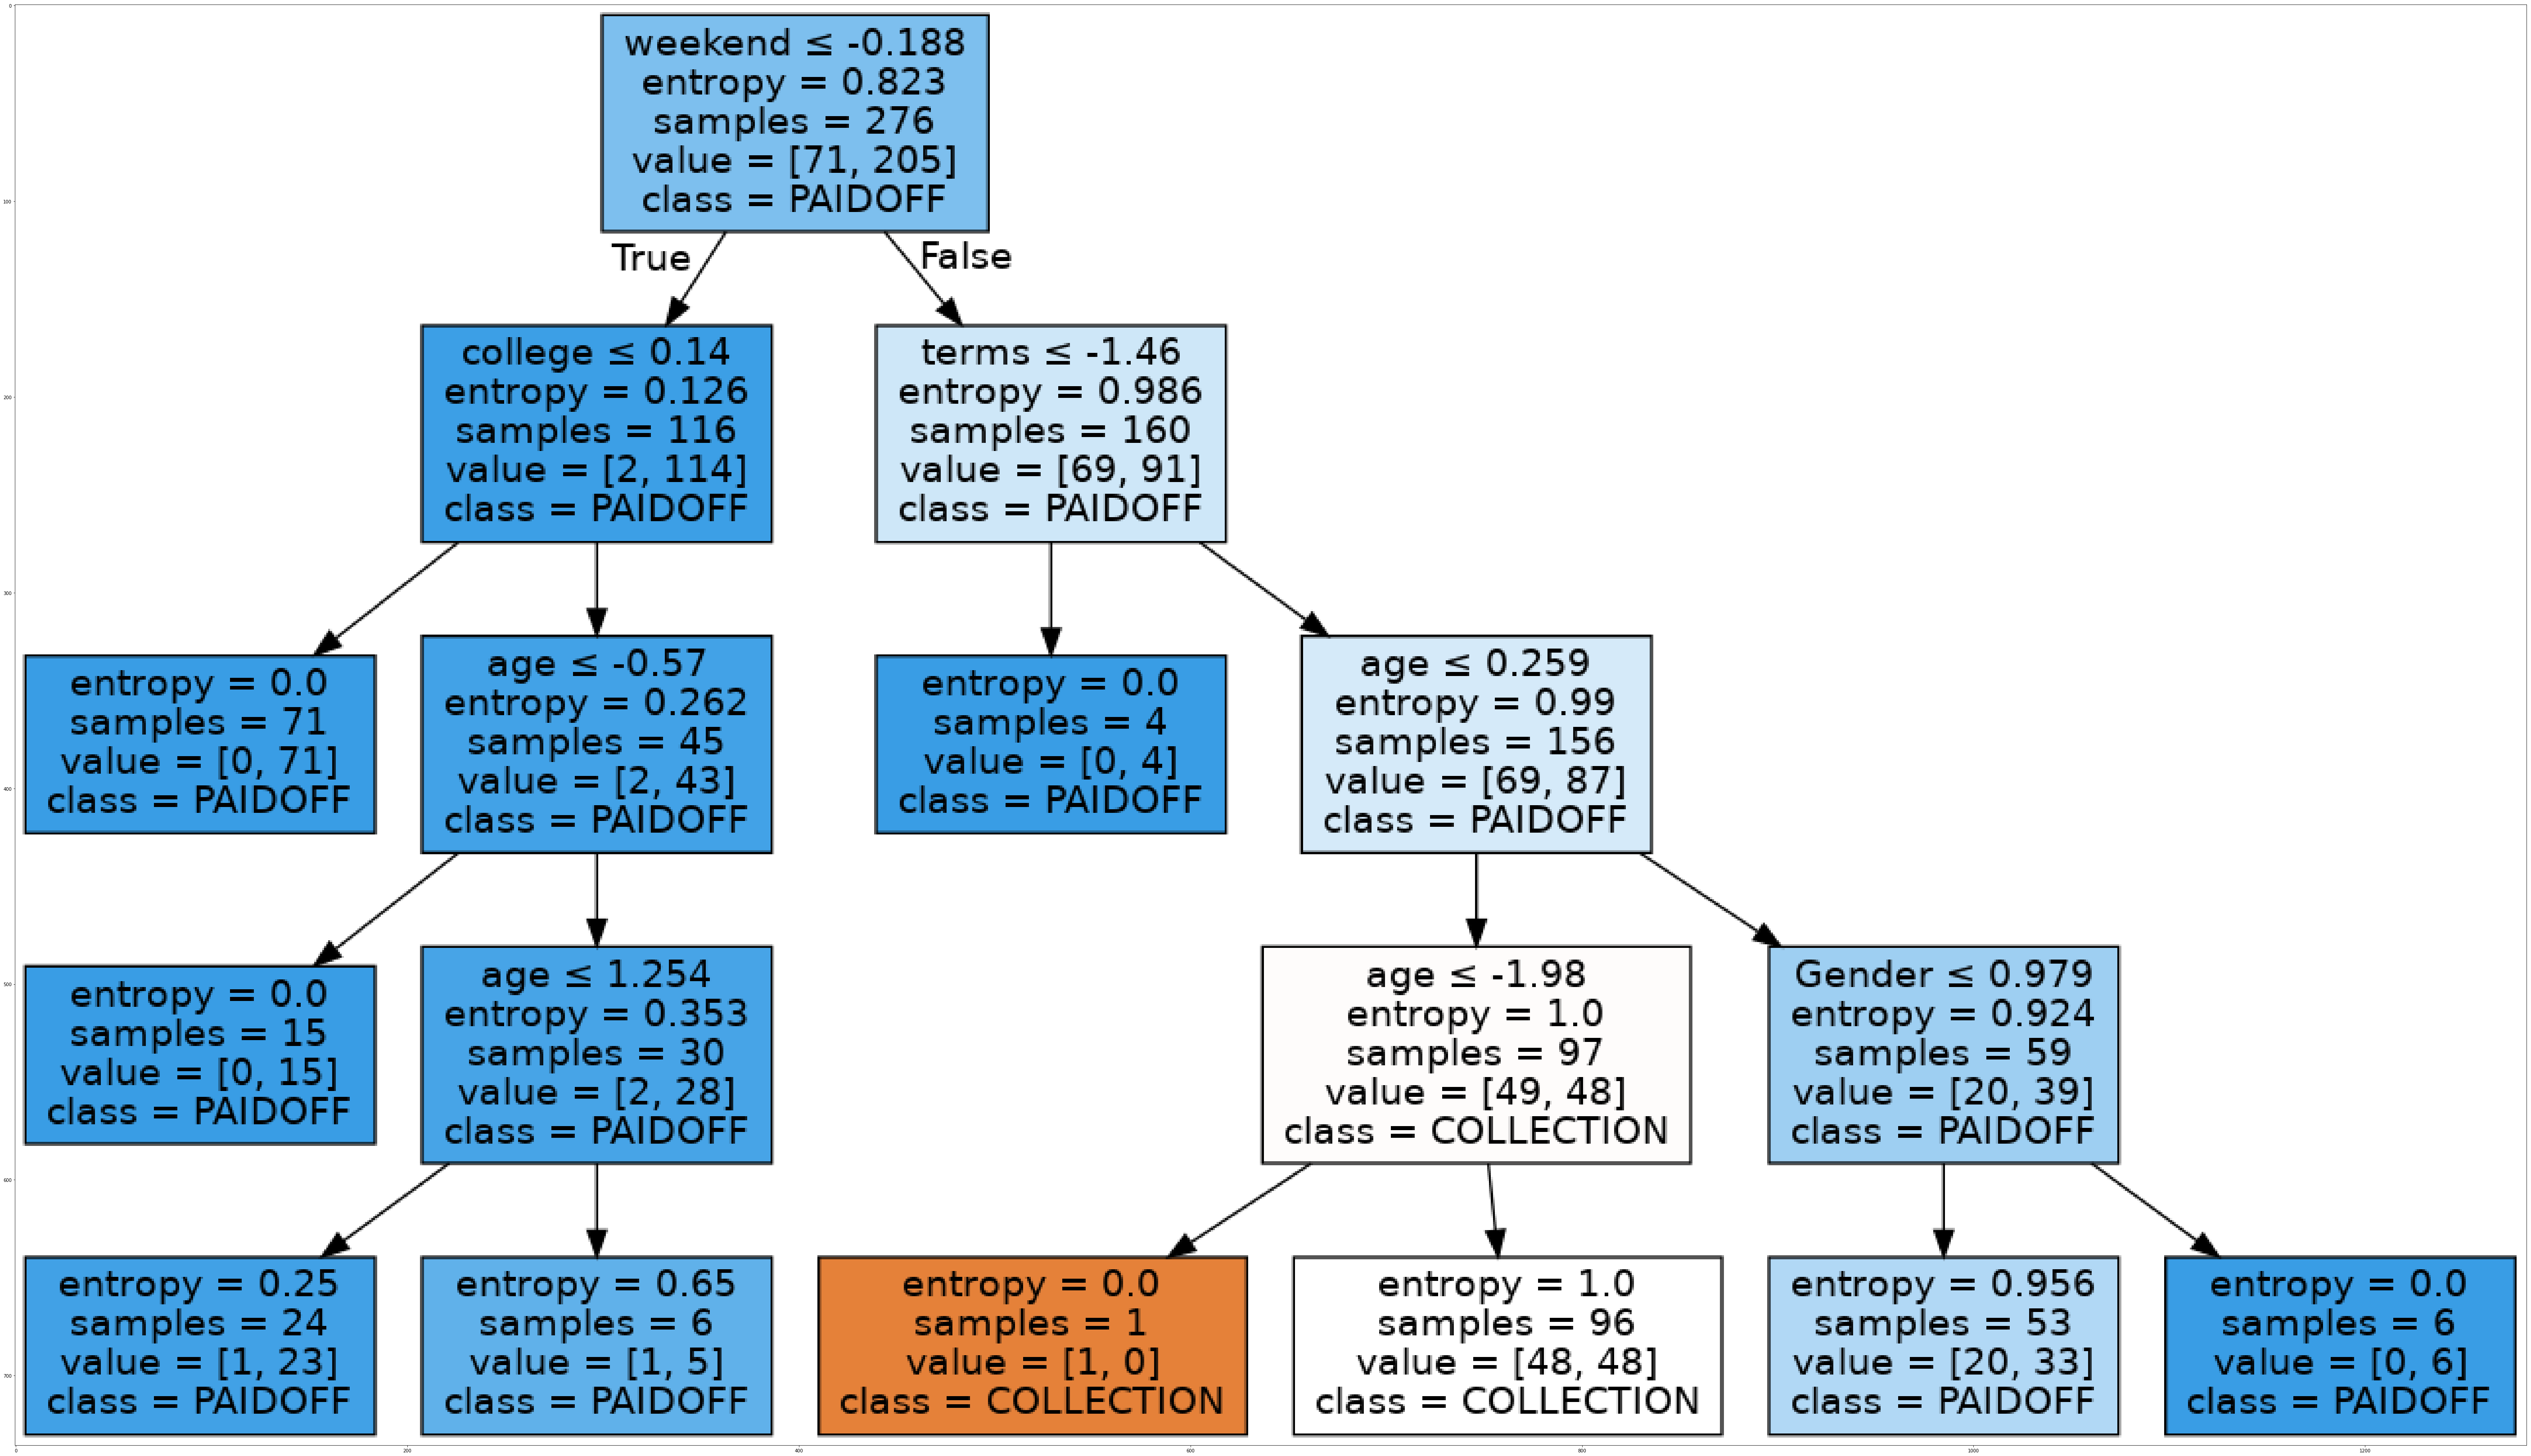

In [46]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[:]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [104]:
from sklearn import svm

In [106]:
#Create a SVM using each of the different kernels
loanSVM_rbf = svm.SVC(kernel='rbf', gamma='auto').fit(X_train, y_train) 
loanSVM_linear = svm.SVC(kernel='linear', gamma='auto').fit(X_train, y_train)
loanSVM_poly = svm.SVC(kernel='poly', gamma='auto').fit(X_train, y_train)
loanSVM_sig = svm.SVC(kernel='sigmoid', gamma='auto').fit(X_train, y_train)

In [108]:
yhat_rbf = loanSVM_rbf.predict(X_test)
yhat_linear = loanSVM_linear.predict(X_test)
yhat_poly = loanSVM_poly.predict(X_test)
yhat_sig = loanSVM_sig.predict(X_test)

In [109]:
#Find Jaccard Index
print("Train Accuracy, rbf: ", metrics.jaccard_similarity_score(y_train, loanSVM_rbf.predict(X_train)))
print("Train Accuracy, linear: ", metrics.jaccard_similarity_score(y_train, loanSVM_linear.predict(X_train)))
print("Train Accuracy, poly: ", metrics.jaccard_similarity_score(y_train, loanSVM_poly.predict(X_train)))
print("Train Accuracy, sigmoid: ", metrics.jaccard_similarity_score(y_train, loanSVM_sig.predict(X_train)))

print("Test Accuracy, rbf: ", metrics.jaccard_similarity_score(y_test, yhat_rbf))
print("Test Accuracy, linear: ", metrics.jaccard_similarity_score(y_test, yhat_linear))
print("Test Accuracy, poly: ", metrics.jaccard_similarity_score(y_test, yhat_poly))
print("Test Accuracy, sigmoid: ", metrics.jaccard_similarity_score(y_test, yhat_sig))

Train Accuracy, rbf:  0.782608695652174
Train Accuracy, linear:  0.7427536231884058
Train Accuracy, poly:  0.782608695652174
Train Accuracy, sigmoid:  0.7101449275362319
Test Accuracy, rbf:  0.7428571428571429
Test Accuracy, linear:  0.7857142857142857
Test Accuracy, poly:  0.7714285714285715
Test Accuracy, sigmoid:  0.7428571428571429


The polynomial kernel seems to work best, so we will continue to evaluate the loanSVM_poly SVM.

In [110]:
#Evaluation, F1 score and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion matrix, without normalization
[[53  2]
 [14  1]]


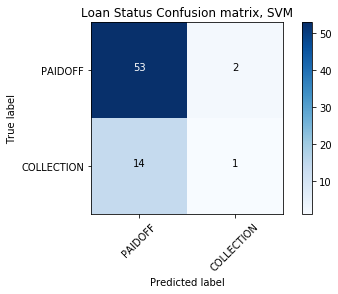

In [118]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_poly, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_poly))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Loan Status Confusion matrix, SVM')

In [119]:
#Find F1 Score
print("Train accuracy, F1 Score, poly: ", f1_score(y_train, loanSVM_poly.predict(X_train), average='weighted'))
print("Test accuracy, F1 Score, poly: ", f1_score(y_test, yhat_poly, average='weighted'))

Train accuracy, F1 Score, poly:  0.7285590159465721
Test accuracy, F1 Score, poly:  0.7064793130366899


# Logistic Regression

In [120]:
#Create logistic regression model

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [121]:
yhat_LR = LR.predict(X_test)

In [122]:
#Find Jaccard Index
print("Train set Accuracy: ", metrics.jaccard_similarity_score(y_train, LR.predict(X_train)))
print("Test set Accuracy: ", metrics.jaccard_similarity_score(y_test, yhat_LR))

Train set Accuracy:  0.7572463768115942
Test set Accuracy:  0.6857142857142857


              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[46  9]
 [13  2]]


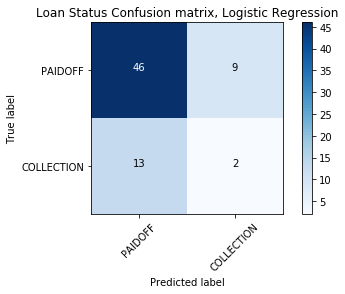

In [123]:
# Compute another confusion matrix
cnf_matrix1 = confusion_matrix(y_test, yhat_LR, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_LR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Loan Status Confusion matrix, Logistic Regression')

In [124]:
#Find F1 Score
print("Train accuracy, F1 Score: ", f1_score(y_train, LR.predict(X_train), average='weighted'))
print("Test accuracy, F1 Score: ", f1_score(y_test, yhat_LR, average='weighted'))

Train accuracy, F1 Score, poly:  0.7341146337750953
Test accuracy, F1 Score, poly:  0.6670522459996144


In [128]:
#Log loss
from sklearn.metrics import log_loss

yhat_LRprob = LR.predict_proba(X_test)
print("Log loss: ", log_loss(y_test, yhat_LRprob) )

Log loss:  0.5772287609479654


# Model Evaluation using Test set

In [129]:
#from sklearn.metrics import jaccard_similarity_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import log_loss

First, download and load the test set:

In [130]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-10 19:56:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-10 19:56:58 (362 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [165]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male

In [166]:
#Convert date time objects
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

In [167]:
#Get weekend feature
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [168]:
#Encode gender
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [191]:
#More one hot encoding
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_Feature.head()

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college  
0        0  
1        0  
2        0  
3        1  
4        0

In [192]:
#Create test sets
X_final_test = test_Feature
X_final_test = preprocessing.StandardScaler().fit(X_final_test).transform(X_final_test)
y_final_test = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [193]:
print('X shape', X_final_test.shape)
print('Y shape', y_final_test.shape)

X shape (54, 8)
Y shape (54,)


In [199]:
#KNN Evaluation
yhat_KNN_final = knnClassifier.predict(X_final_test)
KNN_jaccard = metrics.jaccard_similarity_score(y_final_test, yhat_KNN_final)
KNN_f1 = f1_score(y_final_test, yhat_KNN_final, average='weighted')
print("Jaccard Index: ", KNN_jaccard)
print("F1 Score: ", KNN_f1 )

Jaccard Index:  0.6666666666666666
F1 Score:  0.6328400281888654


In [200]:
#Decision Tree Evaluation
yhat_tree_final = loanTree.predict(X_final_test)
tree_jaccard = metrics.jaccard_similarity_score(y_final_test, yhat_tree_final)
tree_f1 = f1_score(y_final_test, yhat_tree_final, average='weighted')
print("Jaccard Index: ", tree_jaccard )
print("F1 Score: ", tree_f1)

Jaccard Index:  0.7222222222222222
F1 Score:  0.7366818873668188


In [201]:
#SVM Evaluation
yhat_SVM_final = loanSVM_poly.predict(X_final_test)
SVM_jaccard = metrics.jaccard_similarity_score(y_final_test, yhat_SVM_final)
SVM_f1 = f1_score(y_final_test, yhat_SVM_final, average='weighted')
print("Jaccard Index: ", SVM_jaccard)
print("F1 Score: ", SVM_f1)

Jaccard Index:  0.7592592592592593
F1 Score:  0.6959228135698723


In [202]:
#Logistic Regression Evaluation
yhat_LR_final = LR.predict(X_final_test)
yhat_LRprob_final = LR.predict_proba(X_final_test)
LR_jaccard = metrics.jaccard_similarity_score(y_final_test, yhat_LR_final)
LR_f1 = f1_score(y_final_test, yhat_LR_final, average='weighted')
LR_logLoss = log_loss(y_final_test, yhat_LRprob_final)

print("Jaccard Index: ", LR_jaccard)
print("F1 Score: ", LR_f1)
print("Log loss: ", LR_logLoss)

Jaccard Index:  0.7407407407407407
F1 Score:  0.6604267310789049
Log loss:  0.5672153379912981


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [212]:
accuracyData = [['KNN',KNN_jaccard, KNN_f1],['Decision Tree',tree_jaccard, tree_f1],['SVM', SVM_jaccard, SVM_f1], ['LogisticRegression', LR_jaccard, LR_f1, LR_logLoss]]
accuracy_df = pd.DataFrame(accuracyData,columns=['Algorithm','Jaccard', 'F1-score', 'LogLoss'])
accuracy_df.set_index('Algorithm')

Jaccard  F1-score   LogLoss
Algorithm                                       
KNN                 0.666667  0.632840       NaN
Decision Tree       0.722222  0.736682       NaN
SVM                 0.759259  0.695923       NaN
LogisticRegression  0.740741  0.660427  0.567215

It appears that the SVM was the most accurate model.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>